In [197]:
# analysis
import numpy as np
import pandas as pd

# visualize
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(font_scale=1.05, style='whitegrid', palette='bright')

# for nlp 
from nltk import word_tokenize, Text, FreqDist
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from pymorphy2 import MorphAnalyzer
import re
import string

# Посмотрим на данные

In [174]:
train = pd.read_csv('dataset/train.tsv', sep='\t')
test = pd.read_csv('dataset/test.tsv', sep='\t')
print('Количество заголовков в тренировочном датасете: ', len(train))
print('Количество заголовков в тестовом датасете: ', len(test))

Количество заголовков в тренировочном датасете:  5758
Количество заголовков в тестовом датасете:  1000


In [175]:
# распределение классов
train.groupby('is_fake').count().reset_index() \
                        .rename(columns={'title':'count'}, 
                               index={0:'real', 1: 'fake'}) \
                        .drop('is_fake', axis=1)

,count
real,2879
fake,2879


In [176]:
classes = {0:'REAL', 1:'FAKE'}

# 50 заголовков и их метки
for i in range(0, 500, 10):
    title, target = train.iloc[i].title, train.iloc[i].is_fake
    print(f'|{classes[target]}|: {title}')

|FAKE|: Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы
|FAKE|: Марат Хуснуллин призвал прописать в законе понятие многонационального дома
|REAL|: Ubisoft анонсировала новую часть игры Ghost Recon
|FAKE|: В Ольгино объяснили большое количество комментариев под сообщением Володина о QR-кодах
|REAL|: Инженеры Cisco Systems создали сорокаядерный процессор
|REAL|: Fox начала работу над экранизацией Вольтрона
|FAKE|: Из-за сбоя приложения «Моя конституция» в России могут ввести конституционную монархию
|REAL|: Росприроднадзор потребовал отозвать лицензии у британских нефтяников
|FAKE|: Доллар рухнул после отказа ФНБ от американской валюты
|REAL|: Старую PlayStation расплавили c помощью газа и термита
|FAKE|: Любовь Соболь пообещала продолжить борьбу в Сирии
|FAKE|: Депутаты Думы устроили давку и драку во время распродажи долларов по льготному курсу
|REAL|: Словари ABBYY Lingvo получили функцию видеоперевода
|FAKE|: ВШЭ установила 90-процентную квоту при приёме 

Исходя из исходного датасета (*и здравого смысла*) заголовки, относящиеся к классу REAL(0), в большинстве своем постулируют **факты**:  
- «Барселона» вышла в четвертьфинал Лиги чемпионов
- Бывший форвард сборной ЮАР по футболу погиб в ДТП  
- Инженеры Cisco Systems создали сорокаядерный процессор  

Заголовки, относящиеся к классу FAKE(1), - это, по большей части, **громкие новости**, порой не поддающиеся логическому обоснованию (*Алиса Теплякова планирует выйти на пенсию в 18 лет*). В них, на первый взгляд, чаще звучат имена ('Андрей Кондрашов', 'Станислав Черчесов', 'Ольга Бузова', ...) и запреты ('запретить, незаконный',...).

# Распределения
Посчитаем статистики имеющихся данных и посмотрим на распределения относительно этих статистик по каждому классу.
## По словам

In [177]:
# количество слов в заголовке
train['words_count'] = train.title.apply(lambda sen: len(sen.split()))
train.head(5)

,title,is_fake,words_count
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1,10
1,Агент Кокорина назвал езду по встречке житейск...,0,8
2,Госдума рассмотрит возможность введения секрет...,1,8
3,ФАС заблокировала поставку скоростных трамваев...,0,7
4,Против Навального завели дело о недоносительст...,1,8


In [178]:
# Статистики по количеству слов для реальных новостей
train[train.is_fake==0].words_count.describe()

count    2879.000000
mean        7.353595
std         1.805331
min         3.000000
25%         6.000000
50%         7.000000
75%         9.000000
max        15.000000
Name: words_count, dtype: float64

In [179]:
# Статистики по количеству слов для выдуманных новостей
train[train.is_fake==1].words_count.describe()

count    2879.000000
mean       10.093783
std         2.964738
min         3.000000
25%         8.000000
50%        10.000000
75%        12.000000
max        37.000000
Name: words_count, dtype: float64

Text(0.5, 1.0, 'Распределение по словам')

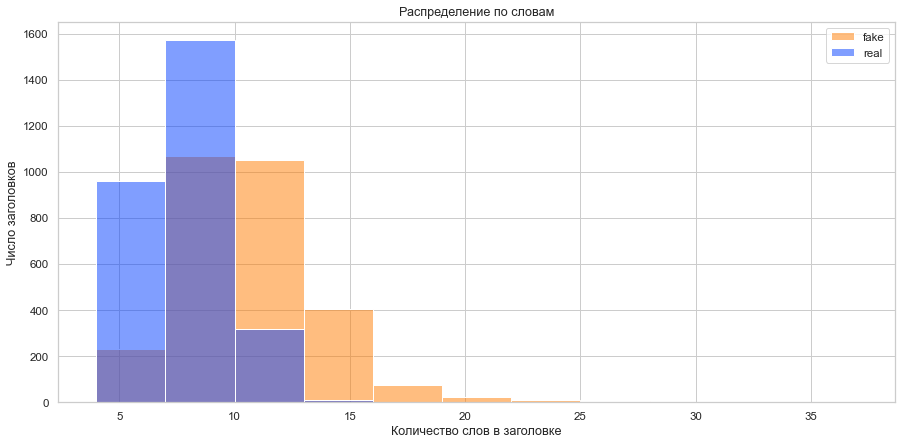

In [180]:
# визуально
plt.figure(figsize=(15, 7))
sns.histplot(data = train, x='words_count', hue='is_fake', binrange=(4, 37), stat='count', binwidth=3)
plt.legend(['fake', 'real'])
plt.xlabel('Количество слов в заголовке')
plt.ylabel('Число заголовков')
plt.title('Распределение по словам')

Наблюдается тенденция: *чем больше слов в заголовке, тем вероятнее то, что он относится классу FAKE*. При этом выдуманных новостей, в которых примерно 4-6 слов, - очень мало по сравнению с реальными новостями (с тем же количество слов). Более того, максимальный по длине заголовок в *реальных новостях* состоит всего из 15 слов.


Как известно, для текстов, "сильно" отличающихся по длине, хорошо подходит **разреженное векторное представление**. В случае такого представления будут хорошо работать линейные модели. Однако такой подход плохо учитывает семантику предложения.

## По пунктационным знакам
Рассмотрим теперь, как часто в выдуманных и реальных новостях встречаются разные знаки препинания

In [181]:
punct_chars = string.punctuation + "«»"
# количество пунктационных знаков в заголовке
train['puncts_count'] = train.title.apply(lambda sen: len([ch for ch in sen if ch in punct_chars]))
display(train.tail(10))

,title,is_fake,words_count,puncts_count
5748,Московский чиновник после получения крупной вз...,1,9,0
5749,Resistance: Retribution выйдет в марте,0,5,1
5750,Экономика Франции избежала рецессии,0,4,0
5751,Российский чемпион Олимпиады-2008 перешел в пр...,0,7,1
5752,Устроивший пробку контейнеровоз не выпустят из...,1,8,0
5753,Эдди Чемберс получил сотрясение мозга в бою с ...,0,9,0
5754,Правительство застроит Россию нефтепродуктопро...,0,4,0
5755,«Мне стыдно перед дедом»: новый канцлер ФРГ об...,1,13,3
5756,Туркмения в декабре начнет поставки газа в Китай,0,8,0
5757,Бывший тренер Локомотива возглавил нальчикский...,0,6,0


Text(0.5, 1.0, 'Распределение по пунктационным знакам')

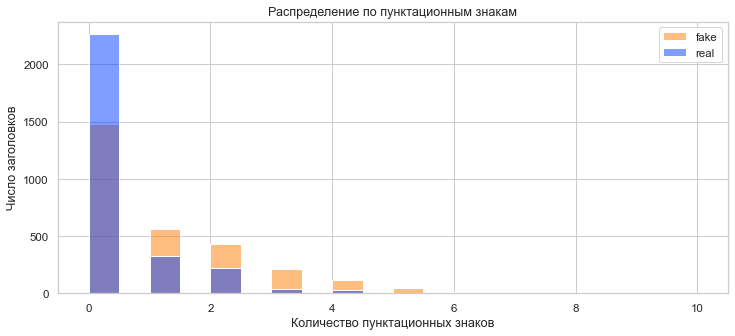

In [182]:
plt.figure(figsize=(12, 5))
sns.histplot(data = train, x='puncts_count', hue='is_fake', stat='count', binwidth=0.5)
plt.legend(['fake', 'real'])
plt.xlabel('Количество пунктационных знаков')
plt.ylabel('Число заголовков')
plt.title('Распределение по пунктационным знакам')

В случае пунктационных знаков наблюдается похожая ситуация: *чем больше знаков, тем заголовок ближе (по вероятности) к классу FAKE*.

 # Частотный анализ
 Рассмотрим, какие слова встречаются наиболее часто
 
## Токенизация без предобработки

In [183]:
train['lower_title'] = train.title.apply(lambda sen: sen.lower())
words = word_tokenize(" ".join(train.lower_title.tolist()))
tokens = Text(words)

print(f'Количество слов: ', len(tokens)) 
tokensFreq  = FreqDist(tokens)
tokensFreq.most_common(10)

Количество слов:  53397


[('в', 2493),
 ('на', 1246),
 ('»', 995),
 ('«', 994),
 (',', 695),
 ('с', 500),
 ('и', 494),
 ('за', 433),
 ('россии', 401),
 ('по', 382)]

Очевидно, что самые часто встречаемые слова - это, так называемые, **стоп-слова** (предлоги, союзы и прочее). Интересен тот факт, что первое **простое слово**, которое встречается в заголовках, - это слово "Россия". Кроме того, легко заметить, что очень часто встречаются кавычки - '«' и '»' (отметим также, что их частота отличается на единичку => где-то, вероятно, есть "артефакт"). Это говорит о том, что в определенном числе заголовков присутствуют цитаты/названия чего-либо).

In [184]:
# попробуем найти артефакты, если они есть
titles = train.title.tolist()
print('Всего заголовков: ', len(titles))
print()

tmp_count = 0
for t in titles:
    left, right = len(re.findall('«', t)), len(re.findall('»', t))
    if left == right:
        if left != 0:
            tmp_count += 1
    else:
        # артефакт
        print(t)

print()
print(f'Число заголовков с цитатами/названиями: ', tmp_count)

Всего заголовков:  5758

Джейми Оливер: «Книга о вкусной и здоровой пище» — моя Библия»
Видеоклип «Победа» ломает виолончели» набрал 12 миллионов просмотров за два дня
«Мы готовим перезапуск телепередачи «Форт Боярд»: Константин Эрнст раскрыл истинное назначение дворца под Геленджиком

Число заголовков с цитатами/названиями:  885


Посмотрим, выполняется ли **Закон Ципфа**:

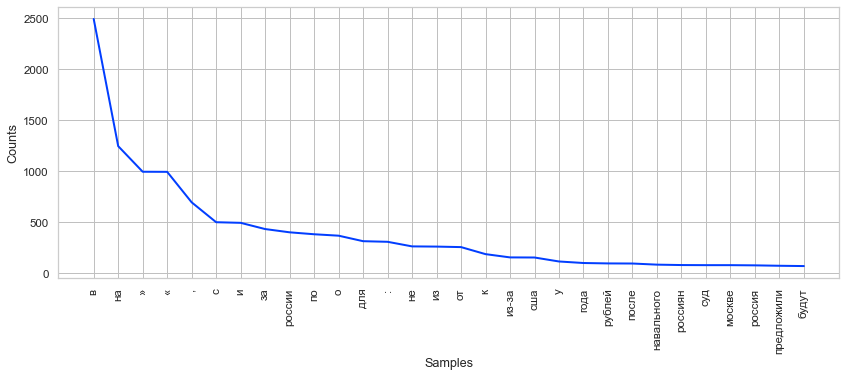

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [185]:
plt.figure(figsize=(14, 5))
display(tokensFreq.plot(30))

## Токенизация без стоп-слов и знаков пунктуации

In [186]:
# punct_chars <- знаки пунктуации
russian_stop_words = stopwords.words("russian")
russian_stop_words.extend(['из-за'])


def delete_stop_and_punct(sentence):
    tokens = word_tokenize(sentence)
    result = []
    for t in tokens:
        if (t in russian_stop_words) or (t in punct_chars):
            continue
        else:
            result.append(t)
    return ' '.join(result)

# убираем стоп-слова и знаки пунктуации
train['no_punct_and_stops'] = train.lower_title.apply(delete_stop_and_punct)
train.tail(5)

,title,is_fake,words_count,puncts_count,lower_title,no_punct_and_stops
5753,Эдди Чемберс получил сотрясение мозга в бою с ...,0,9,0,эдди чемберс получил сотрясение мозга в бою с ...,эдди чемберс получил сотрясение мозга бою кличко
5754,Правительство застроит Россию нефтепродуктопро...,0,4,0,правительство застроит россию нефтепродуктопро...,правительство застроит россию нефтепродуктопро...
5755,«Мне стыдно перед дедом»: новый канцлер ФРГ об...,1,13,3,«мне стыдно перед дедом»: новый канцлер фрг об...,стыдно дедом новый канцлер фрг обратился перво...
5756,Туркмения в декабре начнет поставки газа в Китай,0,8,0,туркмения в декабре начнет поставки газа в китай,туркмения декабре начнет поставки газа китай
5757,Бывший тренер Локомотива возглавил нальчикский...,0,6,0,бывший тренер локомотива возглавил нальчикский...,бывший тренер локомотива возглавил нальчикский...


In [190]:
# подсчитаем частоты слов для нового формата
# отдельно для каждого класса

words_real = word_tokenize(" ".join(train[train.is_fake==0].no_punct_and_stops.tolist())) 
tokens_real = Text(words_real) # токены для реальных новостей

words_fake = word_tokenize(" ".join(train[train.is_fake==1].no_punct_and_stops.tolist())) 
tokens_fake = Text(words_fake) # токены для выдуманных новостей

print('Количество слов (после удаления стоп-слов и знаков пунктуации): ')
print(f'|FAKE| -> {len(tokens_fake)} \n|REAL| -> {len(tokens_real)}\n\
      Всего - {len(tokens_fake)+len(tokens_real)}')

tokensFreq_real  = FreqDist(tokens_real)
tokensFreq_fake  = FreqDist(tokens_fake)

Количество слов (после удаления стоп-слов и знаков пунктуации): 
|FAKE| -> 23548 
|REAL| -> 17757
      Всего - 41305


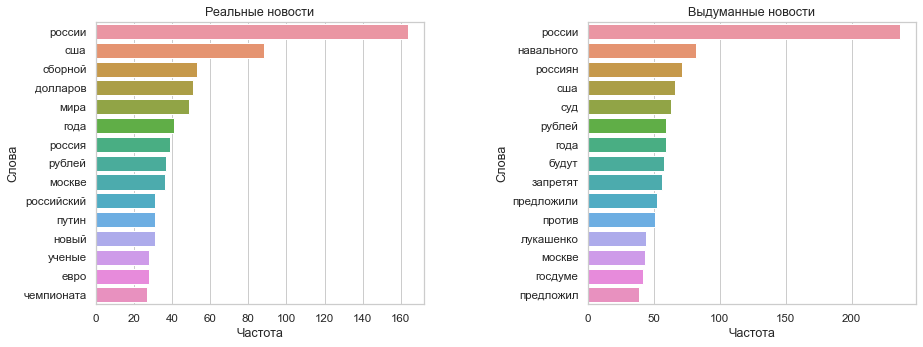

In [191]:
df_fake = pd.DataFrame(tokensFreq_fake.most_common(15), columns=['Слова', 'Частота'])
df_real = pd.DataFrame(tokensFreq_real.most_common(15), columns=['Слова', 'Частота'])

f, axs = plt.subplots(1, 2, figsize=(13, 5))
sns.barplot(y="Слова", x="Частота",  data=df_real, ax=axs[0])
sns.barplot(y="Слова", x="Частота",  data=df_fake, ax=axs[1])
axs[0].set_title('Реальные новости')
axs[1].set_title('Выдуманные новости')
f.tight_layout()
plt.subplots_adjust(wspace=0.5)

Частотный анализ заголовков без стоп-слов и знаков пунктуации не выявляет особых различий (вцелом встречаются похожие слова).  
$\color{red}{!}$Зато подтверждается наша гипотеза о том, что в выдуманных новостях часто встречаются *запреты*.



## Токенизация с нормализацией
Нетрудно заметить, что в приведенных выше словарях часто встречаются разные формы очень похожих слов, например: "России", "Российский", "Россия", "Россиян". Такие "взаимосвязанные" слова являются препятствием к качественному анализу имеющихся данных и, кроме того, они могут повлиять на обобщающую способность модели. По этой причине есть смысл рассмотреть более продвинутую токенизацию.

### Стэмминг

In [213]:
snow_stem = SnowballStemmer(language='russian')

def stemming(sentence):
    tokens = word_tokenize(sentence)
    result = []
    for t in tokens:
        result.append(snow_stem.stem(t))
    return ' '.join(result)

train['stemming'] = train['no_punct_and_stops'].apply(stemming)
train.head(10)

,title,is_fake,words_count,puncts_count,lower_title,no_punct_and_stops,stemming
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1,10,0,москвичу владимиру клутину пришёл счёт за вмеш...,москвичу владимиру клутину пришёл счёт вмешате...,москвич владимир клутин пришел счет вмешательс...
1,Агент Кокорина назвал езду по встречке житейск...,0,8,0,агент кокорина назвал езду по встречке житейск...,агент кокорина назвал езду встречке житейской ...,агент кокорин назва езд встречк житейск истор
2,Госдума рассмотрит возможность введения секрет...,1,8,0,госдума рассмотрит возможность введения секрет...,госдума рассмотрит возможность введения секрет...,госдум рассмотр возможн введен секретн стат уг...
3,ФАС заблокировала поставку скоростных трамваев...,0,7,0,фас заблокировала поставку скоростных трамваев...,фас заблокировала поставку скоростных трамваев...,фас заблокирова поставк скоростн трамва москв
4,Против Навального завели дело о недоносительст...,1,8,0,против навального завели дело о недоносительст...,против навального завели дело недоносительстве...,прот навальн завел дел недоносительств волков
5,Российским студентам запретят учиться за рубежом,1,6,0,российским студентам запретят учиться за рубежом,российским студентам запретят учиться рубежом,российск студент запрет уч рубеж
6,Путин пишет книгу об истории Украины,1,6,0,путин пишет книгу об истории украины,путин пишет книгу истории украины,путин пишет книг истор украин
7,Россияне обхитрили рост цен,0,4,0,россияне обхитрили рост цен,россияне обхитрили рост цен,россиян обхитр рост цен
8,Звезда «Ворониных» раскрыл подробности о своем...,0,7,2,звезда «ворониных» раскрыл подробности о своем...,звезда ворониных раскрыл подробности своем сос...,звезд воронин раскр подробн сво состоян
9,Microsoft объявила дату выхода очков дополненн...,0,8,0,microsoft объявила дату выхода очков дополненн...,microsoft объявила дату выхода очков дополненн...,microsoft объяв дат выход очк дополнен реально...


Количество слов (стэмминг + удаление стоп-слов и знаков пунктуации): 
|FAKE| -> 23548 
|REAL| -> 17757
      Всего - 41305


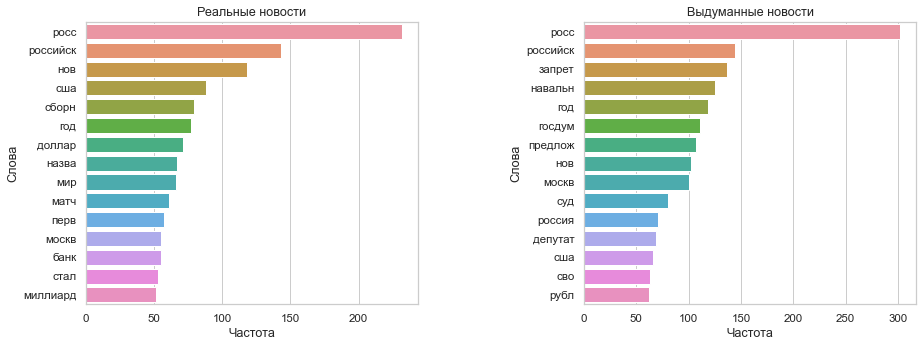

In [222]:
# подсчитаем частоты слов после стемминга
# отдельно для каждого класса
# и посмотрим на самые распространенные слова

STEM_words_real = word_tokenize(" ".join(train[train.is_fake==0].stemming.tolist())) 
STEM_tokens_real = Text(STEM_words_real) # токены для реальных новостей

STEM_words_fake = word_tokenize(" ".join(train[train.is_fake==1].stemming.tolist())) 
STEM_tokens_fake = Text(STEM_words_fake) # токены для выдуманных новостей

print('Количество слов (стэмминг + удаление стоп-слов и знаков пунктуации): ')
print(f'|FAKE| -> {len(STEM_tokens_fake)} \n|REAL| -> {len(STEM_tokens_real)}\n\
      Всего - {len(STEM_tokens_fake)+len(STEM_tokens_real)}')

STEM_tokensFreq_real  = FreqDist(STEM_tokens_real)
STEM_tokensFreq_fake  = FreqDist(STEM_tokens_fake)

STEM_df_fake = pd.DataFrame(STEM_tokensFreq_fake.most_common(15), columns=['Слова', 'Частота'])
STEM_df_real = pd.DataFrame(STEM_tokensFreq_real.most_common(15), columns=['Слова', 'Частота'])

f, axs = plt.subplots(1, 2, figsize=(13, 5))
sns.barplot(y="Слова", x="Частота",  data=STEM_df_real, ax=axs[0])
sns.barplot(y="Слова", x="Частота",  data=STEM_df_fake, ax=axs[1])
axs[0].set_title('Реальные новости')
axs[1].set_title('Выдуманные новости')
f.tight_layout()
plt.subplots_adjust(wspace=0.5)

### Лемматизация

In [223]:
morh = MorphAnalyzer()
def lemmatization(sentence):
    tokens = word_tokenize(sentence)
    result = []
    for t in tokens:
        result.append(morh.normal_forms(t)[0])
    return ' '.join(result)

train['lemmatization'] = train.no_punct_and_stops.apply(lemmatization)
train.tail(5)

,title,is_fake,words_count,puncts_count,lower_title,no_punct_and_stops,stemming,lemmatization
5753,Эдди Чемберс получил сотрясение мозга в бою с ...,0,9,0,эдди чемберс получил сотрясение мозга в бою с ...,эдди чемберс получил сотрясение мозга бою кличко,эдд чемберс получ сотрясен мозг бо кличк,эдди чемберс получить сотрясение мозг бой кличко
5754,Правительство застроит Россию нефтепродуктопро...,0,4,0,правительство застроит россию нефтепродуктопро...,правительство застроит россию нефтепродуктопро...,правительств застро росс нефтепродуктопровод,правительство застроить россия нефтепродуктопр...
5755,«Мне стыдно перед дедом»: новый канцлер ФРГ об...,1,13,3,«мне стыдно перед дедом»: новый канцлер фрг об...,стыдно дедом новый канцлер фрг обратился перво...,стыдн дед нов канцлер фрг обрат перв реч бунде...,стыдно дед новый канцлер фрг обратиться первый...
5756,Туркмения в декабре начнет поставки газа в Китай,0,8,0,туркмения в декабре начнет поставки газа в китай,туркмения декабре начнет поставки газа китай,туркмен декабр начнет поставк газ кита,туркмения декабрь начать поставка газ китай
5757,Бывший тренер Локомотива возглавил нальчикский...,0,6,0,бывший тренер локомотива возглавил нальчикский...,бывший тренер локомотива возглавил нальчикский...,бывш тренер локомотив возглав нальчикск спартак,бывший тренер локомотив возглавить нальчикский...


Количество слов (лемматизация + удаление стоп-слов и знаков пунктуации): 
|FAKE| -> 23548 
|REAL| -> 17757
      Всего - 41305


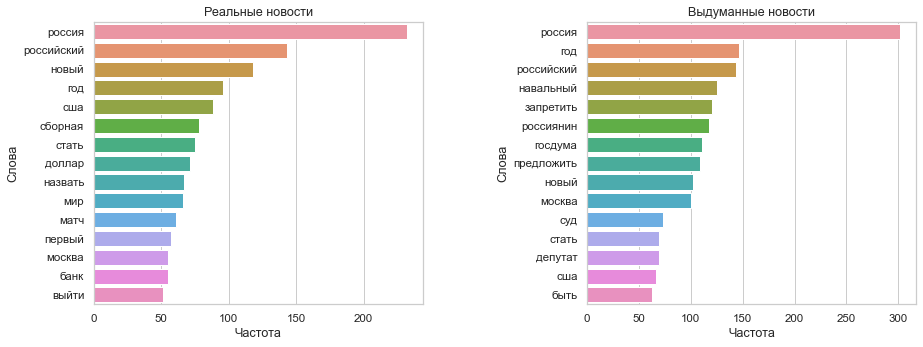

In [224]:
# подсчитаем частоты слов после лемматизации
# отдельно для каждого класса
# и посмотрим на самые распространенные слова

LEMM_words_real = word_tokenize(" ".join(train[train.is_fake==0].lemmatization.tolist())) 
LEMM_tokens_real = Text(LEMM_words_real) # токены для реальных новостей

LEMM_words_fake = word_tokenize(" ".join(train[train.is_fake==1].lemmatization.tolist())) 
LEMM_tokens_fake = Text(LEMM_words_fake) # токены для выдуманных новостей

print('Количество слов (лемматизация + удаление стоп-слов и знаков пунктуации): ')
print(f'|FAKE| -> {len(LEMM_tokens_fake)} \n|REAL| -> {len(LEMM_tokens_real)}\n\
      Всего - {len(LEMM_tokens_fake)+len(LEMM_tokens_real)}')

LEMM_tokensFreq_real  = FreqDist(LEMM_tokens_real)
LEMM_tokensFreq_fake  = FreqDist(LEMM_tokens_fake)

LEMM_df_fake = pd.DataFrame(LEMM_tokensFreq_fake.most_common(15), columns=['Слова', 'Частота'])
LEMM_df_real = pd.DataFrame(LEMM_tokensFreq_real.most_common(15), columns=['Слова', 'Частота'])

f, axs = plt.subplots(1, 2, figsize=(13, 5))
sns.barplot(y="Слова", x="Частота",  data=LEMM_df_real, ax=axs[0])
sns.barplot(y="Слова", x="Частота",  data=LEMM_df_fake, ax=axs[1])
axs[0].set_title('Реальные новости')
axs[1].set_title('Выдуманные новости')
f.tight_layout()
plt.subplots_adjust(wspace=0.5)